In [ ]:
from src.components.nn_data_ingestion import FraudDetectionDataset
from src.baseline.data_ingestion import DataIngestorFactory, DataIngestorConfig
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint  # Updated import
from src.utils import setup_logger, seed_everything
from src.exception import CustomException
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import numpy as np
from dataclasses import dataclass
from abc import ABC, abstractmethod
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings

# Suppress pandas UserWarning to avoid cluttering logs
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

# Initialize logger for tracking preprocessing steps
logger = setup_logger()

@dataclass
class PreprocessorConfig:
    """Configuration for preprocessing steps.

    Attributes:
        windows_size (list): List of window sizes (in days) for rolling calculations, e.g., [1, 7, 30].
        delay (int): Delay period (in days) for terminal characteristics, e.g., 7.
    """
    windows_size = [1, 7, 30]
    delay = 7

class ProcessingStep(ABC):
    """Abstract base class for defining preprocessing steps.

    All preprocessing steps must inherit from this class and implement the `process` method.
    """

    @abstractmethod
    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """Apply a preprocessing step to the DataFrame.

        Args:
            df (pd.DataFrame): Input DataFrame to process.

        Returns:
            pd.DataFrame: Processed DataFrame with added or modified columns.

        Raises:
            CustomException: If an error occurs during processing.
        """
        pass

class WeekendStep(ProcessingStep):
    """Preprocessing step to add a binary indicator for transactions occurring on weekends.

    Creates a column `TX_DURING_WEEKEND` with value 1 if the transaction occurs on Saturday or Sunday, else 0.
    """

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add a binary column indicating if the transaction occurred on a weekend.

        Args:
            df (pd.DataFrame): Input DataFrame with a `TX_DATETIME` column (datetime).

        Returns:
            pd.DataFrame: DataFrame with new `TX_DURING_WEEKEND` column.

        Raises:
            CustomException: If an error occurs while processing the `TX_DATETIME` column.
        """
        ##logger.info("Starting WeekendStep")
        try:
            df["TX_DURING_WEEKEND"] = df["TX_DATETIME"].apply(lambda x: 1 if x.weekday() >= 5 else 0)
            return df
        except Exception as e:
            logger.error(f"Error in WeekendStep: {e}")
            raise CustomException(e, sys)

class NightStep(ProcessingStep):
    """Preprocessing step to add a binary indicator for transactions occurring at night.

    Creates a column `TX_DURING_NIGHT` with value 1 if the transaction occurs between 12 AM and 6 AM, else 0.
    """

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add a binary column indicating if the transaction occurred at night (12 AM to 6 AM).

        Args:
            df (pd.DataFrame): Input DataFrame with a `TX_DATETIME` column (datetime).

        Returns:
            pd.DataFrame: DataFrame with new `TX_DURING_NIGHT` column.

        Raises:
            CustomException: If an error occurs while processing the `TX_DATETIME` column.
        """
        ##logger.info("Starting NightStep")
        try:
            df["TX_DURING_NIGHT"] = df["TX_DATETIME"].apply(lambda x: 1 if x.hour <= 6 else 0)
            return df
        except Exception as e:
            logger.error(f"Error in NightStep: {e}")
            raise CustomException(e, sys)

class CustomerCharacteristicStep(ProcessingStep):
    """Preprocessing step to compute customer-level transaction statistics over rolling windows.

    For each window size in the config, calculates the number of transactions and average transaction amount
    per customer over the specified time window.
    """

    def __init__(self, config: PreprocessorConfig):
        """Initialize the step with a configuration.

        Args:
            config (PreprocessorConfig): Configuration object containing window sizes.
        """
        self.config = config

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """Compute customer-level statistics (transaction count and average amount) for each window size.

        Adds columns like `CUSTOMER_ID_NB_TX_{size}DAY_WINDOW` and `CUSTOMER_ID_AVG_AMOUNT_{size}DAY_WINDOW`
        for each window size in the config.

        Args:
            df (pd.DataFrame): Input DataFrame with columns `CUSTOMER_ID`, `TX_DATETIME`, `TRANSACTION_ID`, and `TX_AMOUNT`.

        Returns:
            pd.DataFrame: DataFrame with new customer statistic columns.

        Raises:
            CustomException: If an error occurs during rolling calculations or merging.
        """
        #logger.info("Starting CustomerCharacteristicStep")
        try:
            df.reset_index(drop=True,inplace=True)
            ##logger.info("Initializing CustomerCharacteristicStep")
            for size in self.config.windows_size:
                ##logger.info(f"Starting for {size}d_WINDOW")
                df.sort_values("TX_DATETIME", inplace=True)
                
                #logger.info("Calculating WINDOW_TX_COUNT")
                WINDOW_TX_COUNT = (
                    df.groupby("CUSTOMER_ID")
                    .rolling(f"{size}d", on="TX_DATETIME")["TRANSACTION_ID"].count()
                    .reset_index()
                    .rename(columns={"TRANSACTION_ID": f"CUSTOMER_ID_NB_TX_{size}DAY_WINDOW"})
                )
                #logger.info(WINDOW_TX_COUNT[f"CUSTOMER_ID_NB_TX_{size}DAY_WINDOW"])
                WINDOW_TX_MEAN = (
                    df.groupby("CUSTOMER_ID")
                    .rolling(f"{size}d", on="TX_DATETIME")["TX_AMOUNT"].mean()
                    .reset_index()
                    .rename(columns={"TX_AMOUNT": f"CUSTOMER_ID_AVG_AMOUNT_{size}DAY_WINDOW"})
                )
                #logger.info(WINDOW_TX_MEAN[f"CUSTOMER_ID_AVG_AMOUNT_{size}DAY_WINDOW"])
                ##logger.info("Merging WINDOW_TX_COUNT and WINDOW_TX_MEAN into df")
                df[f"CUSTOMER_ID_NB_TX_{size}DAY_WINDOW"] = WINDOW_TX_COUNT[f"CUSTOMER_ID_NB_TX_{size}DAY_WINDOW"]
                
                df[f"CUSTOMER_ID_AVG_AMOUNT_{size}DAY_WINDOW"] = WINDOW_TX_MEAN[f"CUSTOMER_ID_AVG_AMOUNT_{size}DAY_WINDOW"]
            return df
        except Exception as e:
            logger.error(f"Error in CustomerCharacteristicStep: {e}")
            raise CustomException(e, sys)

class TerminalCharacteristicStep(ProcessingStep):
    """Preprocessing step to compute terminal-level fraud risk statistics over rolling windows.

    For each window size plus a delay period, calculates the number of transactions and fraud risk
    (ratio of fraudulent transactions to total transactions) per terminal.
    """

    def __init__(self, config: PreprocessorConfig):
        """Initialize the step with a configuration.

        Args:
            config (PreprocessorConfig): Configuration object containing window sizes and delay period.
        """
        self.config = config

    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """Compute terminal-level statistics (transaction count and fraud risk) for each window size.

        Adds columns like `TERMINAL_ID_NB_TX_{size}DAY_WINDOW` and `TERMINAL_ID_RISK_{size}DAY_WINDOW`
        for each window size in the config, accounting for a delay period.

        Args:
            df (pd.DataFrame): Input DataFrame with columns `TERMINAL_ID`, `TX_DATETIME`, and `TX_FRAUD`.

        Returns:
            pd.DataFrame: DataFrame with new terminal statistic columns.

        Raises:
            CustomException: If an error occurs during rolling calculations or merging.
        """
        #logger.info("Starting TerminalCharacteristicStep")
        try:
            ##logger.info("Initializing TerminalCharacteristicStep")
            ##logger.info("Calculating FRAUD_DELAY and TX_DELAY")
            df.reset_index(drop=True,inplace=True)
            FRAUD_DELAY = df.groupby("TERMINAL_ID").rolling(
                f"{self.config.delay}D", on="TX_DATETIME"
            )["TX_FRAUD"].sum()
            TX_DELAY = df.groupby("TERMINAL_ID").rolling(
                f"{self.config.delay}D", on="TX_DATETIME"
            )["TX_FRAUD"].count()

            for size in self.config.windows_size:
                #logger.info(f"Calculating rolling sums/counts for {size}d_WINDOW + delay")
                df.sort_values(["TERMINAL_ID", "TX_DATETIME"], inplace=True)
                
                FRAUD_DELAY_WINDOW = df.groupby("TERMINAL_ID").rolling(
                    f"{size + self.config.delay}D", on="TX_DATETIME"
                )["TX_FRAUD"].sum()
                TX_DELAY_WINDOW = df.groupby("TERMINAL_ID").rolling(
                    f"{size + self.config.delay}D", on="TX_DATETIME"
                )["TX_FRAUD"].count()

                #logger.info(f"Calculating FRAUD_WINDOW, TX_WINDOW, and RISK_WINDOW for {size}d_WINDOW")
                FRAUD_WINDOW = FRAUD_DELAY_WINDOW - FRAUD_DELAY
                TX_WINDOW = TX_DELAY_WINDOW - TX_DELAY
                RISK_WINDOW = FRAUD_WINDOW / TX_WINDOW
                
                #logger.info(f"Inserting TX_WINDOW and RISK_WINDOW to df for {size}d_WINDOW")
                df[f"TERMINAL_ID_NB_TX_{size}DAY_WINDOW"] = TX_WINDOW.reset_index(drop=True).fillna(0)
                df[f"TERMINAL_ID_RISK_{size}DAY_WINDOW"] = RISK_WINDOW.reset_index(drop=True).fillna(0)
            return df
        except Exception as e:
            logger.error(f"Error in TerminalCharacteristicStep: {e}")
            raise CustomException(e, sys)

class SMOTEStep(ProcessingStep):
    """Preprocessing step to apply SMOTE for balancing class distribution.

    Uses Synthetic Minority Oversampling Technique (SMOTE) to generate synthetic samples for the minority class
    to address class imbalance in the dataset.
    """
    def __init__(self, target_minority_percentage: float = 0.5):
        """Initialize the SMOTE step with a target minority percentage.

        Args:
            target_minority_percentage (float): Desired percentage of minority class in the balanced dataset.
        """
        self.target_minority_percentage = target_minority_percentage
        ##logger.info("Initializing SMOTEStep")
    def process(self, df: pd.DataFrame) -> pd.DataFrame:
        """Apply SMOTE to balance the class distribution in the DataFrame.

        Args:
            df (pd.DataFrame): Input DataFrame with input features and output feature defined in DataIngestorConfig.

        Returns:
            pd.DataFrame: Balanced DataFrame with synthetic samples for the minority class.

        Raises:
            CustomException: If an error occurs during SMOTE application (e.g., insufficient minority samples).
        """
        try:
            ##logger.info("Starting SMOTE step")
            
            X_train = df[DataIngestorConfig.input_features_transformed]
            
            y_train = df[DataIngestorConfig.output_feature]
            #logger.info(f"{X_train.isna().sum(),y_train.isna().sum()}")
            # Calculate original class distribution
            n_majority = (y_train == 0).sum()  # Assuming 0 is majority (non-fraud)
            n_minority = (y_train == 1).sum()  # Assuming 1 is minority (fraud)
            total_original = len(df)

            # Calculate target minority samples to achieve the desired percentage
            target_total = total_original + (n_minority * (1 / self.target_minority_percentage - 1))  # Adjust total
            target_minority = target_total * self.target_minority_percentage
            target_majority = target_total - target_minority

            # Calculate the sampling strategy (ratio of new minority to original majority)
            if n_majority == 0:
                raise ValueError("No majority class samples found")
            sampling_strategy = (target_minority - n_minority) / n_majority
            smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)  # 'auto' balances to 1:1
            X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
            #logger.info(f"{X_train_smote.isna().sum(),y_train_smote.isna().sum()}")
            # Create new DataFrame with SMOTE-balanced data
            train_df_smote = pd.DataFrame(X_train_smote, columns=DataIngestorConfig.input_features_transformed)
            train_df_smote[DataIngestorConfig.output_feature] = y_train_smote
            return train_df_smote
        except Exception as e:
            raise CustomException(e, sys)
class ScaleStep(ProcessingStep):
    def process(self, df):
        try:
            # Exclude the target column from scaling
            
            minmax_scaler = MinMaxScaler()
            df_scaled = df.copy()
            df_scaled[DataIngestorConfig.input_features_transformed] = minmax_scaler.fit_transform(df[DataIngestorConfig.input_features_transformed])
            return df_scaled
        except Exception as e:
            logger.error(f"Error in ScaleStep: {e}")
            raise CustomException(e, sys)
class PreprocessorPipeline:
    """Pipeline to execute a sequence of preprocessing steps on a DataFrame.

    Manages a series of processing steps, ensuring each step is applied in order and handles errors appropriately.
    Converts the `TX_DATETIME` column to datetime if necessary.
    """

    def __init__(self, df: pd.DataFrame, exclude_method: list = [],add_method:list =["weekend","night","customer_char","terminal_char","smote",'scale']):
        """Initialize the pipeline with a DataFrame and configuration.

        Args:
            df (pd.DataFrame): Input DataFrame to preprocess.
            exclude_method (list): List of step types to exclude, e.g., ["add features", "scale", "smote"]
        """
        self.df = df.copy()
        smote_ratio = 1
        # Convert TX_DATETIME to datetime if not already in datetime64 format
        if not np.issubdtype(self.df["TX_DATETIME"].dtype, np.datetime64):
            self.df["TX_DATETIME"] = pd.to_datetime(self.df["TX_DATETIME"])
        self.config = PreprocessorConfig()
        # Define steps with tags for exclusion
        steps_with_tags = [
            ("weekend", WeekendStep()),
            ("night", NightStep()),
            ("customer_char", CustomerCharacteristicStep(self.config)),
            ("terminal_char", TerminalCharacteristicStep(self.config)),
            ("smote", SMOTEStep(smote_ratio)),
            ("scale", ScaleStep()),
        ]
        
      
        self.steps = [step for tag, step in steps_with_tags if tag in add_method and tag not in exclude_method]
        

    def process(self) -> pd.DataFrame:
        """Run all preprocessing steps in sequence.

        Returns:
            pd.DataFrame: Fully processed DataFrame after applying all steps.

        Raises:
            CustomException: If any preprocessing step fails.
        """
        current_df = self.df.copy()
        for step in self.steps:
            #logger.info(f"Executing step: {step.__class__.__name__}")
            try:
                current_df = step.process(current_df)
            except Exception as e:
                logger.error(f"Exception in pipeline step {step.__class__.__name__}: {e}")
                raise CustomException(e, sys)
        self.df = current_df
        return self.df



In [4]:

os.chdir(rf"c:\Users\thuhi\workspace\fraud_detection")
print(os.getcwd())

factory = DataIngestorFactory()
ingestor = factory.create_ingestor("duration_pkl")
train_df, validation_df = ingestor.ingest(
    dir_path=rf"C:\Users\thuhi\workspace\fraud_detection\data\raw_data",
    start_train_date="2018-06-01",
    train_duration=1,
    test_duration=30,
    delay=7
)
ingestor = factory.create_ingestor("duration_pkl")
train_df_transformed, validation_df_transformed = ingestor.ingest(
    dir_path=rf"C:\Users\thuhi\workspace\fraud_detection\simulated-data-transformed\data",
    start_train_date="2018-06-01",
    train_duration=1,
    test_duration=30,
    delay=7)



c:\Users\thuhi\workspace\fraud_detection


In [21]:
validation_df_preprocessed = PreprocessorPipeline(validation_df,exclude_method=["smote","scale"]).process()


In [16]:
validation_df_preprocessed.columns

Index(['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID',
       'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD',
       'TX_FRAUD_SCENARIO', 'TX_DURING_WEEKEND', 'TX_DURING_NIGHT',
       'CUSTOMER_ID_NB_TX_1DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
       'CUSTOMER_ID_NB_TX_7DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
       'CUSTOMER_ID_NB_TX_30DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
       'TERMINAL_ID_NB_TX_1DAY_WINDOW', 'TERMINAL_ID_RISK_1DAY_WINDOW',
       'TERMINAL_ID_NB_TX_7DAY_WINDOW', 'TERMINAL_ID_RISK_7DAY_WINDOW',
       'TERMINAL_ID_NB_TX_30DAY_WINDOW', 'TERMINAL_ID_RISK_30DAY_WINDOW'],
      dtype='object')

In [13]:
validation_df_transformed.columns

Index(['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID',
       'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD',
       'TX_FRAUD_SCENARIO', 'TX_DURING_WEEKEND', 'TX_DURING_NIGHT',
       'CUSTOMER_ID_NB_TX_1DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
       'CUSTOMER_ID_NB_TX_7DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
       'CUSTOMER_ID_NB_TX_30DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
       'TERMINAL_ID_NB_TX_1DAY_WINDOW', 'TERMINAL_ID_RISK_1DAY_WINDOW',
       'TERMINAL_ID_NB_TX_7DAY_WINDOW', 'TERMINAL_ID_RISK_7DAY_WINDOW',
       'TERMINAL_ID_NB_TX_30DAY_WINDOW', 'TERMINAL_ID_RISK_30DAY_WINDOW'],
      dtype='object')

In [22]:
(validation_df_transformed.sort_values(["TRANSACTION_ID","TX_DATETIME"]).reset_index(drop=True) ==validation_df_preprocessed.sort_values(["TRANSACTION_ID","TX_DATETIME"]).reset_index(drop=True)).sum()

TRANSACTION_ID                         297458
TX_DATETIME                            297458
CUSTOMER_ID                            297458
TERMINAL_ID                            297458
TX_AMOUNT                              297458
TX_TIME_SECONDS                        297458
TX_TIME_DAYS                           297458
TX_FRAUD                               297458
TX_FRAUD_SCENARIO                      297458
TX_DURING_WEEKEND                      297458
TX_DURING_NIGHT                        297458
CUSTOMER_ID_NB_TX_1DAY_WINDOW           47587
CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW          1
CUSTOMER_ID_NB_TX_7DAY_WINDOW            9808
CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW          1
CUSTOMER_ID_NB_TX_30DAY_WINDOW           1783
CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW         0
TERMINAL_ID_NB_TX_1DAY_WINDOW           96464
TERMINAL_ID_RISK_1DAY_WINDOW           293810
TERMINAL_ID_NB_TX_7DAY_WINDOW           20137
TERMINAL_ID_RISK_7DAY_WINDOW           283403
TERMINAL_ID_NB_TX_30DAY_WINDOW    

In [27]:
data = {
    'CUSTOMER_ID': [1, 1, 1, 2, 2],
    'TX_DATETIME': ['2025-01-01 10:00:00', '2025-01-02 12:00:00', '2025-01-03 15:00:00', 
                    '2025-01-02 14:00:00', '2025-01-02 16:00:00'],
    'TRANSACTION_ID': [101, 102, 103, 201, 202],
    'TX_AMOUNT': [50.00, 75.00, 100.00, 200.00, 150.00]
}
test_df = pd.DataFrame(data)
# Create DataFrame

In [28]:
a = PreprocessorPipeline(test_df,add_method=["customer_char"]).process()
a

,CUSTOMER_ID,TX_DATETIME,TRANSACTION_ID,TX_AMOUNT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
0,1,2025-01-01 10:00:00,101,50.0,1.0,50.0,1.0,50.0,1.0,50.0
1,1,2025-01-02 12:00:00,102,75.0,1.0,75.0,2.0,62.5,2.0,62.5
3,2,2025-01-02 14:00:00,201,200.0,1.0,200.0,1.0,200.0,1.0,200.0
4,2,2025-01-02 16:00:00,202,150.0,2.0,175.0,2.0,175.0,2.0,175.0
2,1,2025-01-03 15:00:00,103,100.0,1.0,100.0,3.0,75.0,3.0,75.0


In [37]:
(validation_df_transformed.sort_values(["TRANSACTION_ID","TX_DATETIME"]).reset_index(drop=True)
 [["TX_DATETIME","CUSTOMER_ID","CUSTOMER_ID_NB_TX_1DAY_WINDOW","CUSTOMER_ID_NB_TX_7DAY_WINDOW"]]
 .sort_values(["CUSTOMER_ID","TX_DATETIME"]))

,TX_DATETIME,CUSTOMER_ID,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW
4238,2018-06-09 11:11:23,0,4.0,11.0
8001,2018-06-09 17:14:20,0,3.0,12.0
12885,2018-06-10 09:48:15,0,3.0,11.0
14081,2018-06-10 11:31:21,0,3.0,11.0
17247,2018-06-10 16:26:51,0,4.0,11.0
...,...,...,...,...
285306,2018-07-08 15:07:20,4999,4.0,19.0
285929,2018-07-08 16:13:53,4999,5.0,20.0
286042,2018-07-08 16:26:49,4999,6.0,20.0
287967,2018-07-08 23:29:19,4999,7.0,21.0


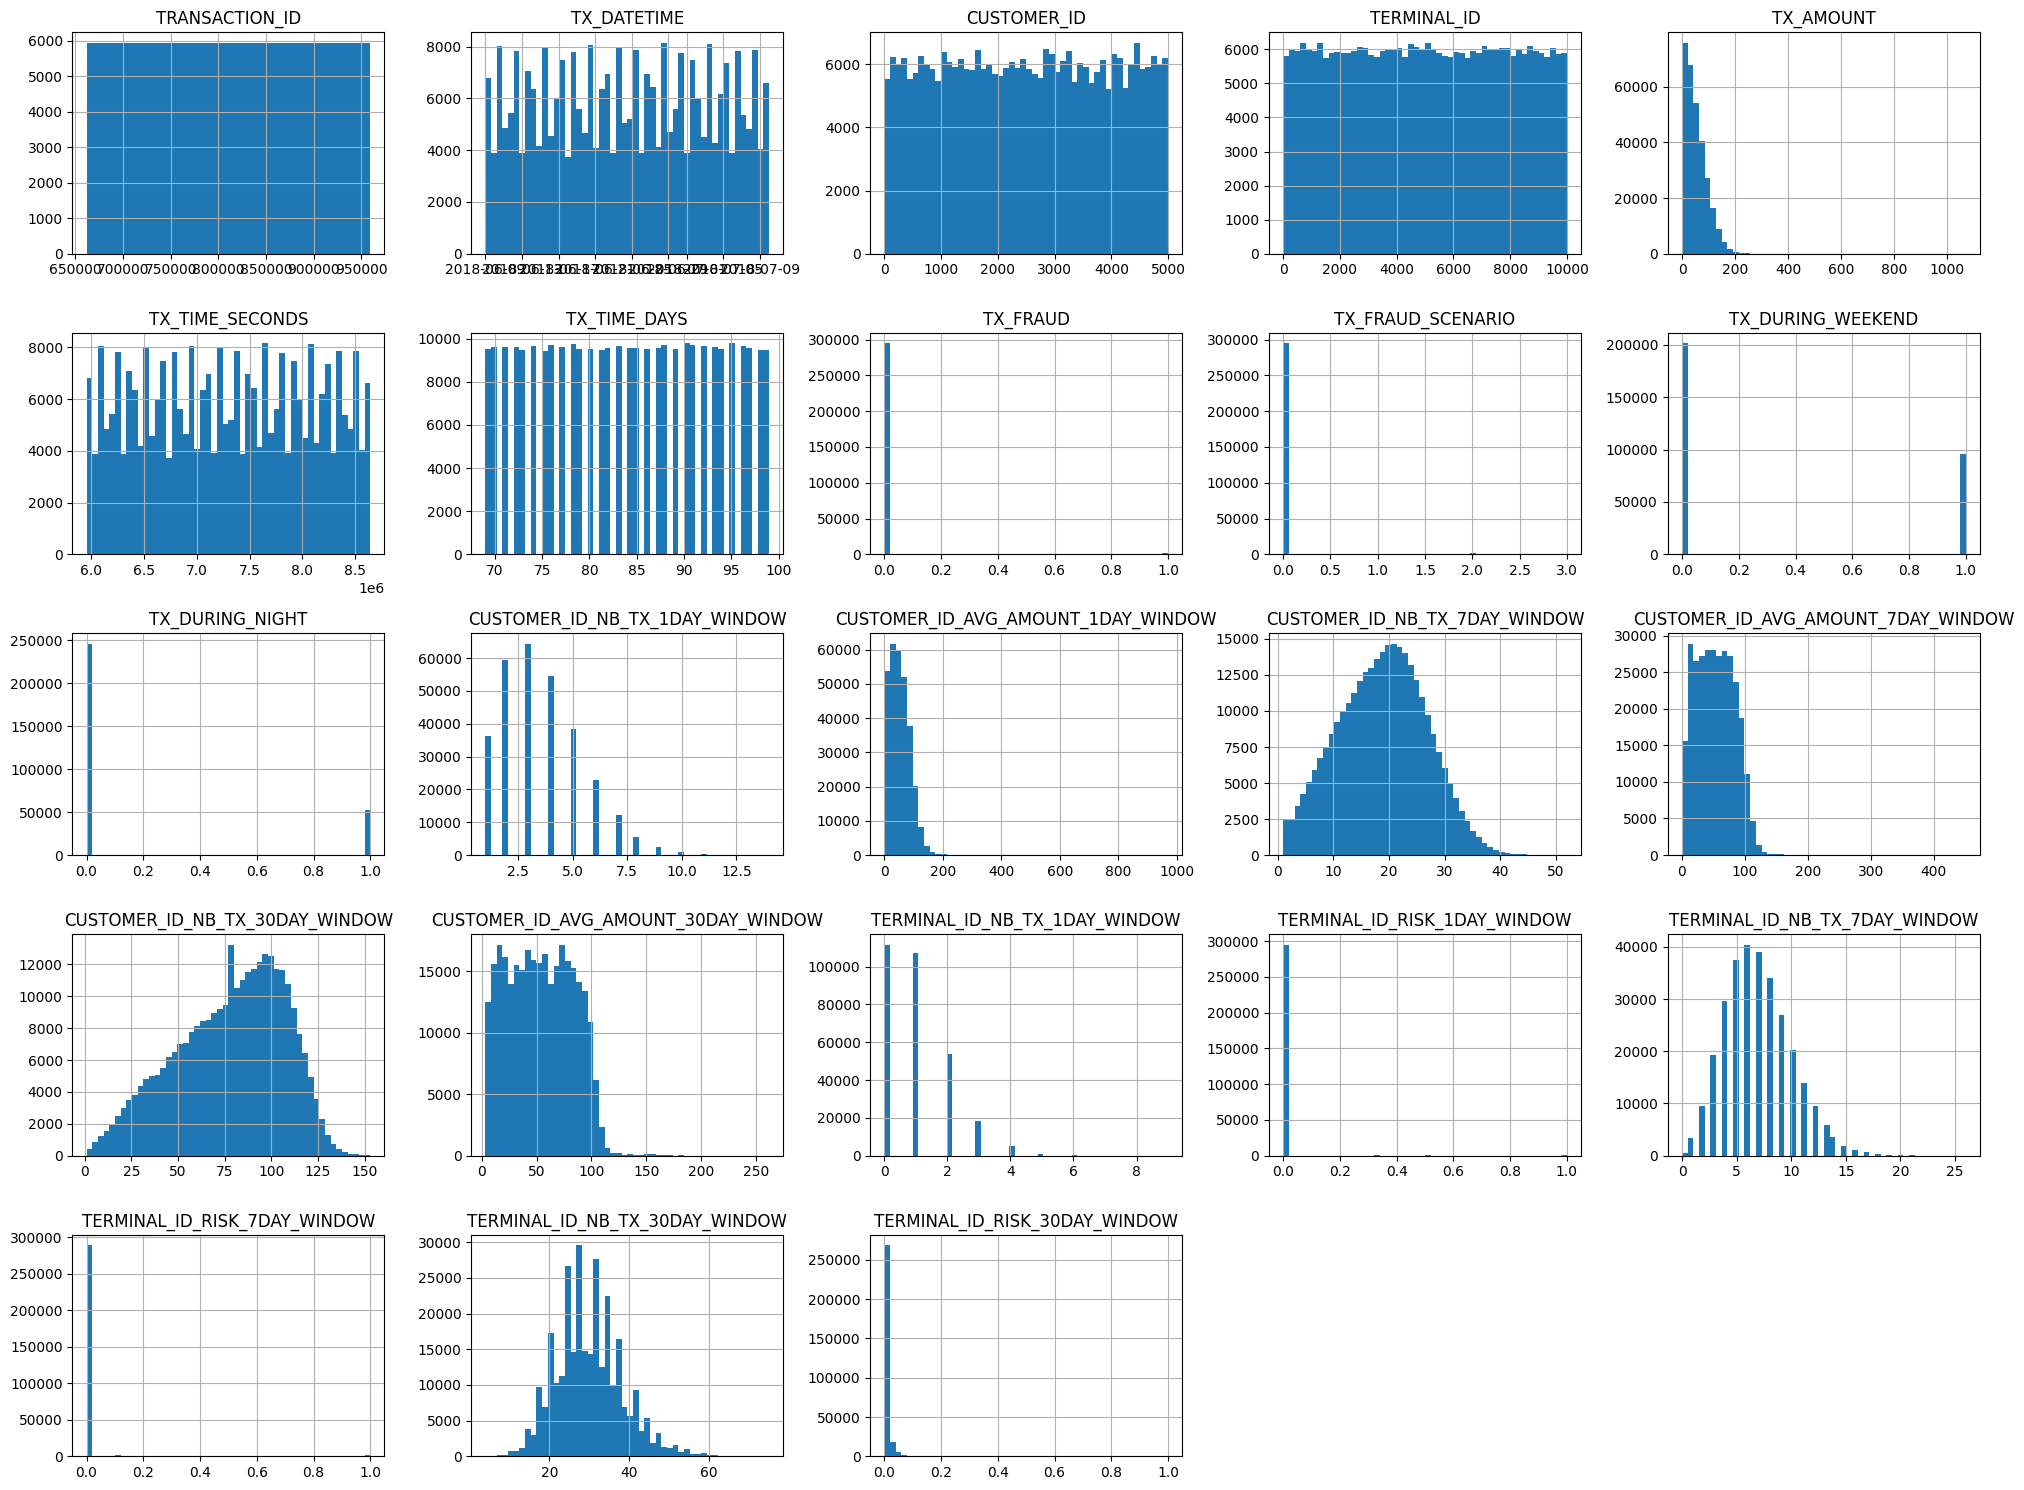

In [43]:
validation_df_transformed.hist(figsize=(20, 15), bins=50)
plt.tight_layout()
plt.show()

In [45]:
df =PreprocessorPipeline(validation_df_transformed,add_method=["scale"]).process()

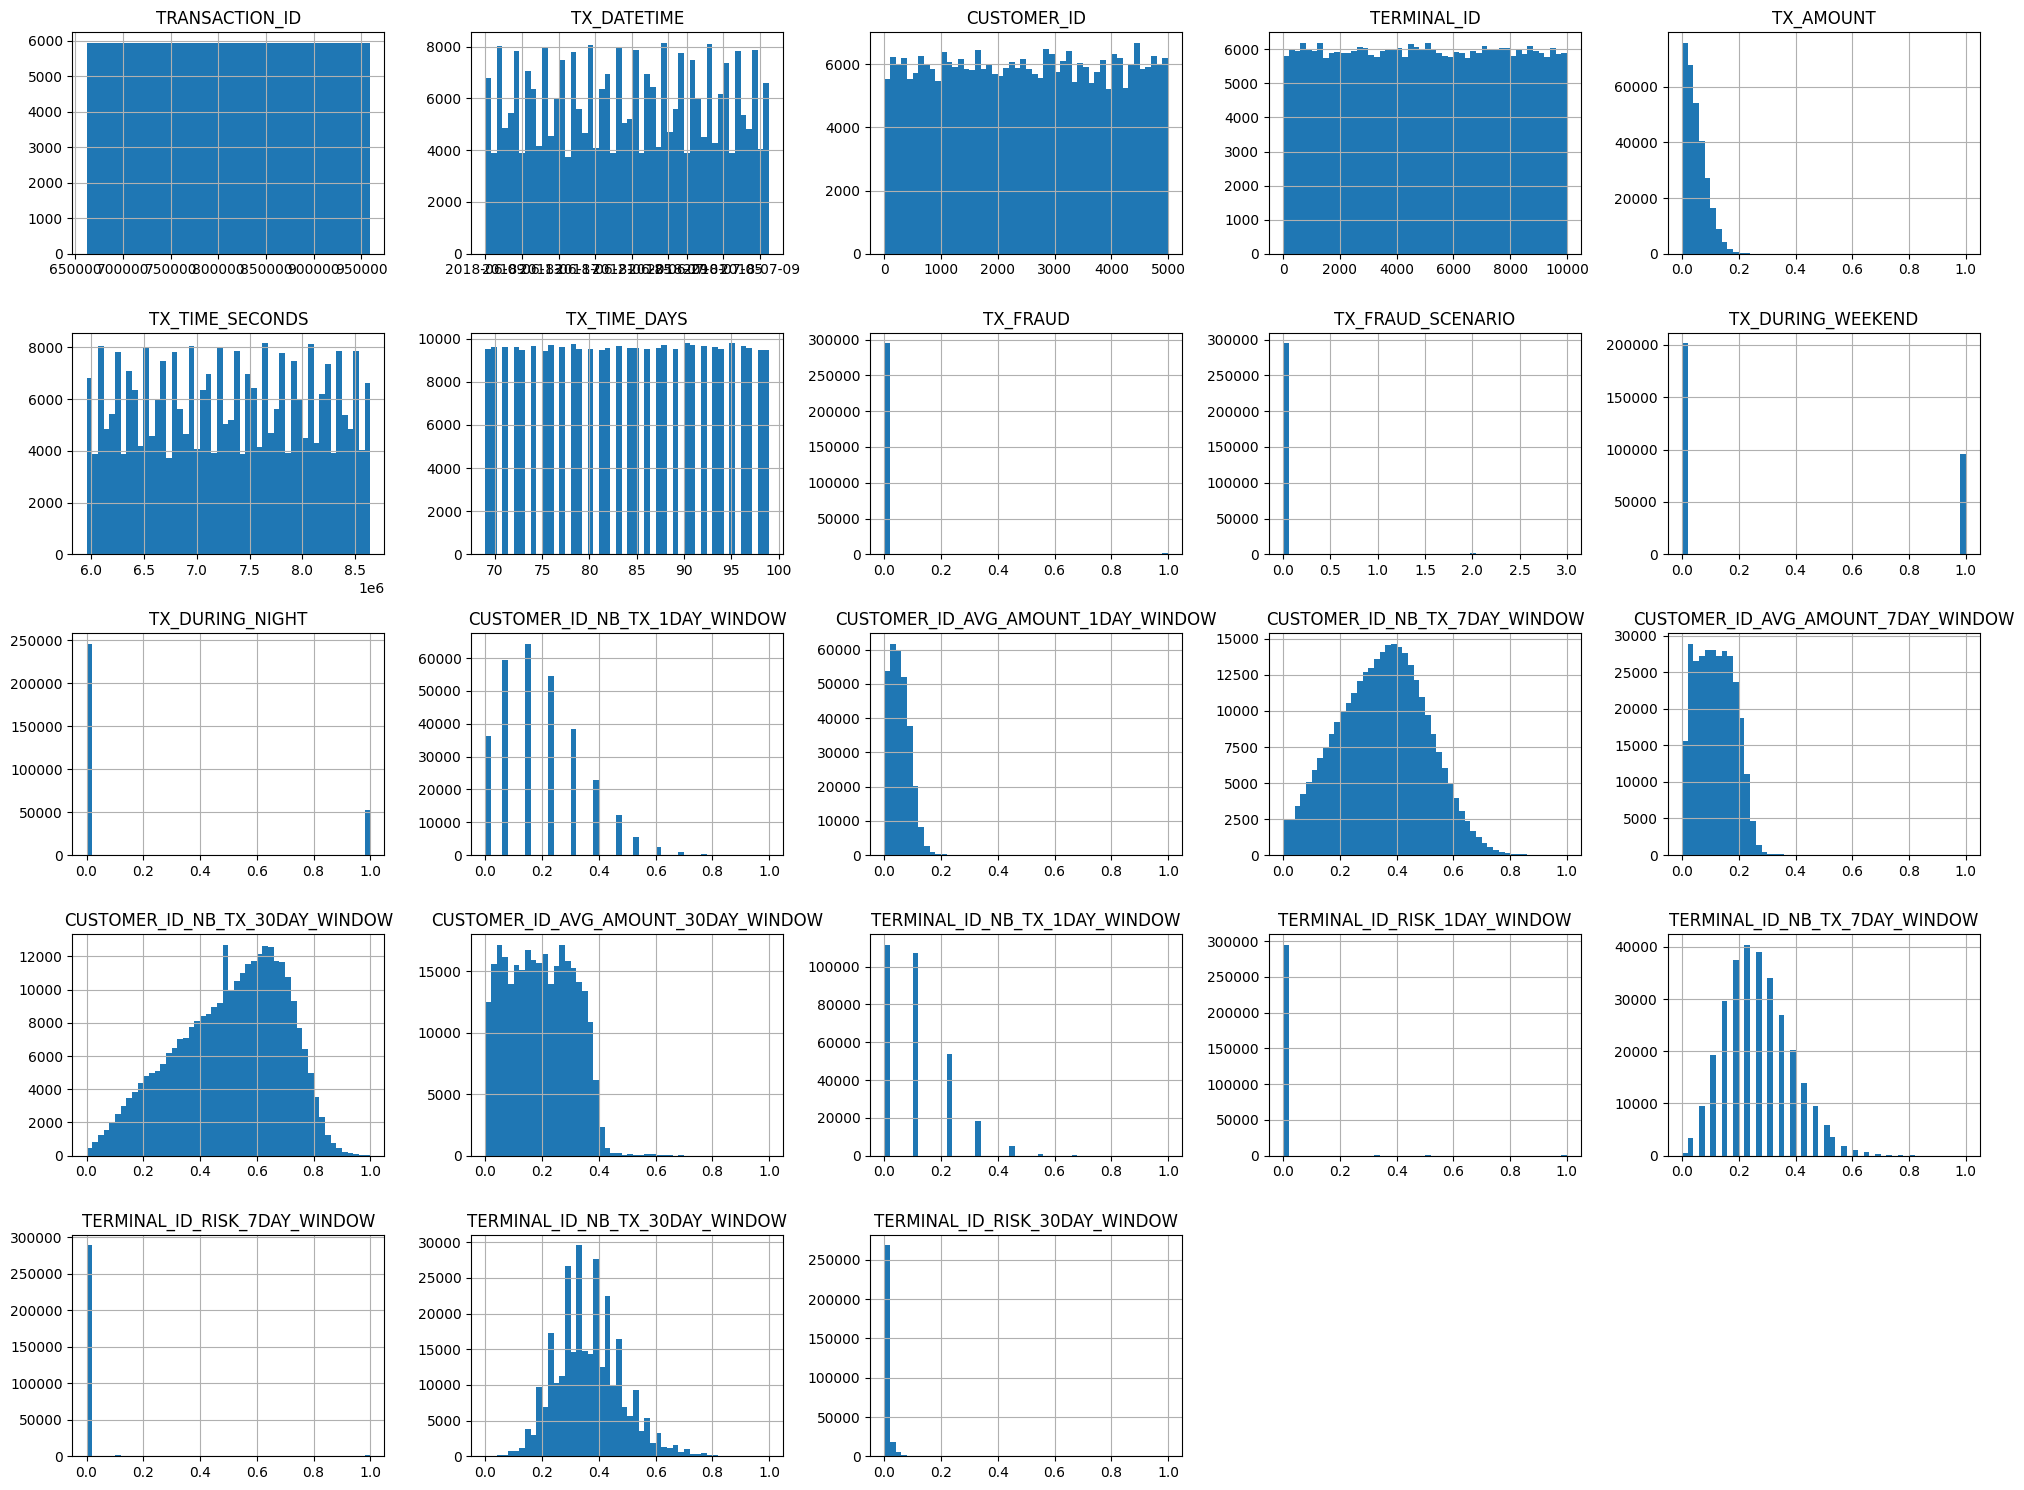

: 

In [ ]:
df.hist(figsize=(20, 15), bins=50)
plt.tight_layout()
plt.show()